In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

import json

%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path_img = './data/RealSR(V3)/canon/train/2'

path_hr_img = './data/div2k/DIV2K_train_HR'
path_lr_x2_img = './data/div2k/DIV2K_train_LR_unknown/X2'
patch_size = (128,128)
images_lr = []
images_hr = []
images_lr_patches = []
images_hr_patches = []
scale=2
data_range=1. #255.


for filename in tqdm(os.listdir(path_img)):
    if filename.find('LR')>0:
        img = read_image(os.path.join(path_img, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_lr.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0], patch_size[1]).unfold(2, patch_size[0], patch_size[1])
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_lr_patches.append(patches[0][i][j])
    else:
        img = read_image(os.path.join(path_img, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_hr.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0]*scale, patch_size[1]*scale).unfold(2, patch_size[0]*scale, patch_size[1]*scale)
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_hr_patches.append(patches[0][i][j])
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:27<00:00, 14.37it/s]


In [4]:
path_img_test = './data/RealSR(V3)/canon/test/2'
patch_size = (128,128)
images_lr_test = []
images_hr_test = []
images_lr_test_patches = []
images_hr_test_patches = []
scale=2
data_range=1. #255.

for filename in tqdm(os.listdir(path_img_test)):
    if filename.find('LR')>0:
        img = read_image(os.path.join(path_img_test, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_lr_test.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0], patch_size[1]).unfold(2, patch_size[0], patch_size[1])
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_lr_test_patches.append(patches[0][i][j])
    else:
        img = read_image(os.path.join(path_img_test, filename))
        transform = torchvision.transforms.Compose([
            v2.ToPureTensor(),
            v2.ToDtype(torch.float)
        ])
        if data_range==1:
            img = transform(img)/255.
        img = torch.clamp(img, 0, data_range)
        images_hr_test.append(img)
        patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0]*scale, patch_size[1]*scale).unfold(2, patch_size[0]*scale, patch_size[1]*scale)
        size = patches[0].shape
        for i in range(size[0]):
            for j in range(size[1]):
                images_hr_test_patches.append(patches[0][i][j])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.48it/s]


In [5]:
images_hr_fathers = []
images_lr_sons = []
scales = [2, 3, 4] #, 5, 6, 7, 8, 9]
scale_son=2

for image in tqdm(images_lr):
    for scale in scales:    
        resizes = {
            'bilinear': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                     antialias=True),
            'nearest': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                     antialias=True),
            'nearest_exact': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                     antialias=True),
            'bicubic': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                     antialias=True),  
        }
        resize_as = random.choice(list(resizes.values()))
        image_downscale = resize_as(image)
        if image_downscale.shape[1] % 2 != 0 or image_downscale.shape[2] %2 != 0:
            new_h = image_downscale.shape[1] - 1 if image_downscale.shape[1] % 2 != 0 else image_downscale.shape[1]
            new_w = image_downscale.shape[2] - 1 if image_downscale.shape[2] % 2 != 0 else image_downscale.shape[2]
            crop = torchvision.transforms.CenterCrop((new_h, new_w))
            image_downscale = crop(image_downscale)
            
        augmenters = {
            #'Rotate90': torchvision.transforms.RandomRotation(degrees=(90,90), expand=True),
            #'Rotate180': torchvision.transforms.RandomRotation(degrees=(180,180), expand=True),
            #'Rotate270': torchvision.transforms.RandomRotation(degrees=(270,270), expand=True),
            'HFlip': torchvision.transforms.RandomHorizontalFlip(p=1),
            'VFlip': torchvision.transforms.RandomVerticalFlip(p=1),
        }
        for (augmenter_name, augmenter) in augmenters.items():
            resizes_son = {
                'bilinear': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                           int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                         antialias=True),
                'nearest': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                         antialias=True),
                'nearest_exact': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                                int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                         antialias=True),
                'bicubic': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                         antialias=True),  
            }
            resize_as = random.choice(list(resizes_son.values()))
            image_downscale_son = resize_as(image_downscale)
            img_aug_father = augmenter(image_downscale)
            img_aug_son = augmenter(image_downscale_son)
            images_hr_fathers.append(img_aug_father)
            images_lr_sons.append(img_aug_son)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.19it/s]


1200
torch.Size([3, 200, 350]) torch.Size([3, 100, 175])


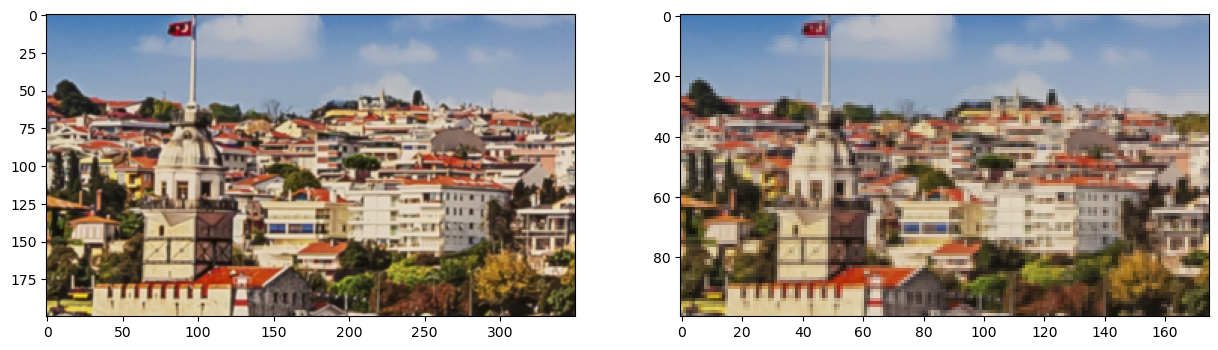

In [6]:
print(len(images_hr_fathers))
n=6
plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(images_hr_fathers[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,2,2)
plt.imshow(images_lr_sons[n].permute(1,2,0)) #.type(torch.LongTensor))
print(images_hr_fathers[n].shape, images_lr_sons[n].shape)

In [7]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [8]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [61]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(*args, **kwargs)
        #self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(*args, **kwargs)
        self.activation2 = nn.ReLU()
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x_input)
        #x = self.bn(x)
        x = self.activation1(x)
        x = self.conv2(x)
        #x = self.bn(x)
        x = self.activation2(x)        
        return x + x_input
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        
        #self.upscale = nn.Upsample(scale_factor=2)
        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        #self.conv = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.GELU(),
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.GELU()
        #)
        #self.conv_resc1 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same'),
        #    nn.GELU()
        #)
        
        
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    
    def forward(self, x):
        x = self.upscale(x)
        #x = self.conv(x) + self.conv_resc1(x)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        x = torch.clamp(x, min=0., max=self.max_value)
        return x


In [21]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv(x_input)
        x = self.activation(x)
        return x # + x_input
        

class zssr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        

        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=(1,1), stride=1, padding='same')
        
       
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.GELU()
        )

    
    def forward(self, x):
        x0 = self.upscale(x)
        x = self.conv_in(x0)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        out = torch.add(x, x0)
        out = torch.clamp(out, min=0., max=self.max_value)
 
        return out

In [22]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None, metrics=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        self.metrics = metrics
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            epoch_metrics = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data)
                del data
                target = batch[1].to(device)
                loss = self.criterion(preds, target)
                loss.backward()
                del target
                del preds
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    del data
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    if self.metrics:
                        metric = self.metrics(preds, target)
                        epoch_metrics.append(metric.numpy(force=True))
                    del target
                    del preds
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1                  
                    
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()
            metric = np.array(epoch_metrics).mean()

            if scheduler:
                scheduler.step(loss) 
                        
            
            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            lr = optimizer.param_groups[0]["lr"]
            
            if self.metrics:
                print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}; metric={metric:.4f}', end='\n')
            else:
                print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}', end='\n')

        return self.history

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [24]:
ds_lr_downscaled = images_dataset(images_lr_sons, images_hr_fathers)
ds_lr_downscaled_train, ds_lr_downscaled_test = torch.utils.data.random_split(ds_lr_downscaled, [0.8, 0.2])

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lr_downscaled_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
dl_lrdown2lr_test = DataLoader(ds_lr_downscaled_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [25]:
def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 1000/loss + 0.01*nn.SmoothL1Loss()(y_pred, y_true)
    return loss

In [26]:
def fft_loss(y_pred, y_true):
    loss = torch.sum(torch.abs(torch.fft.rfft(y_pred, 1)))
    loss = 100/loss + 10*nn.SmoothL1Loss()(y_pred, y_true)
    return loss    

In [27]:
def loss_ssim_l2(y_pred, y_true):
    data_range = 1.
    y_true = torch.clamp(y_true,0,data_range)
    loss_ssim = 1. - ssim(y_pred, y_true, data_range=data_range)
    loss_l2 = nn.MSELoss()(y_pred, y_true)
    del y_true
    del y_pred
    return loss_ssim + loss_l2

In [28]:
def metric_ssim(y_pred, y_true):
    data_range=1.
    y_true = torch.clamp(y_true,0,data_range)    
    return ssim(y_pred, y_true, data_range=data_range)

In [62]:
torch.cuda.empty_cache()
model = lrdown2lr(n_blocks=8, channels=128, max_value=1.).to(device)
print(model)
criterion = loss_ssim_l2
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       metrics= metric_ssim,
                       epochs=40,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

lrdown2lr(
  (upscale): Sequential(
    (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): PixelShuffle(upscale_factor=2)
  )
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (activation1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (activation2): ReLU()
    )
  )
  (conv_out): Sequential(
    (0): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
)
epoch 1/40; train loss: 0.2868, val_loss: 0.2448; lr=0.0001; metric=0.7615
epoch 2/40; train loss: 0.2260, val_loss: 0.2259; lr=0.0001; metric=0.7801
epoch 3/40; train loss: 0.2184, val_loss: 0.2172; lr=0.0001; metric=0.7880
epoch 4/40; train loss: 0.2149, val_loss: 0.2114; lr=0.0001; metric=0.7936
epoch 5/40; train l

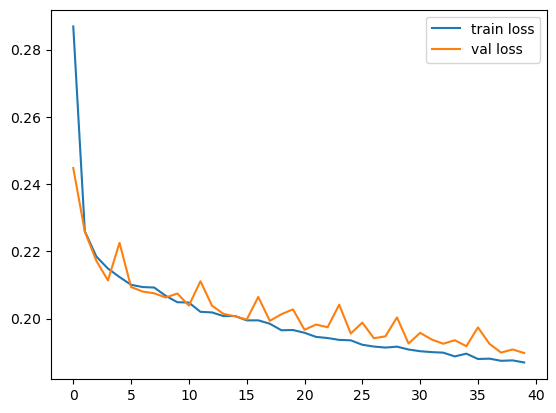

In [63]:
plot_history(history)

In [18]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

In [92]:
ref.min()

tensor(0.)

tensor(0.8704)


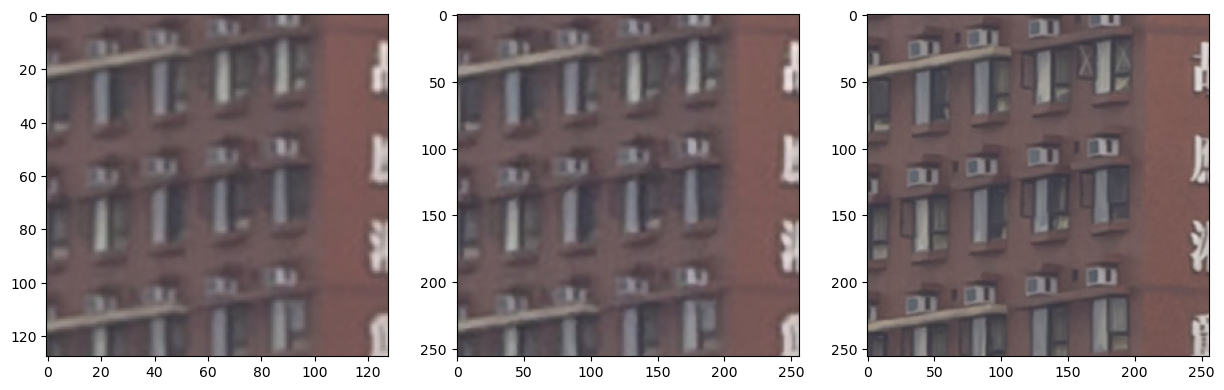

In [64]:
n = 449
ref = images_hr_test_patches[n]

#model = model.to('cpu')
test = images_lr_test_patches[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'div2k_out.png')

plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_test_patches[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img) #.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(ref.permute(1,2,0)) #.type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
print(ssim_after)

tensor(0.9525)


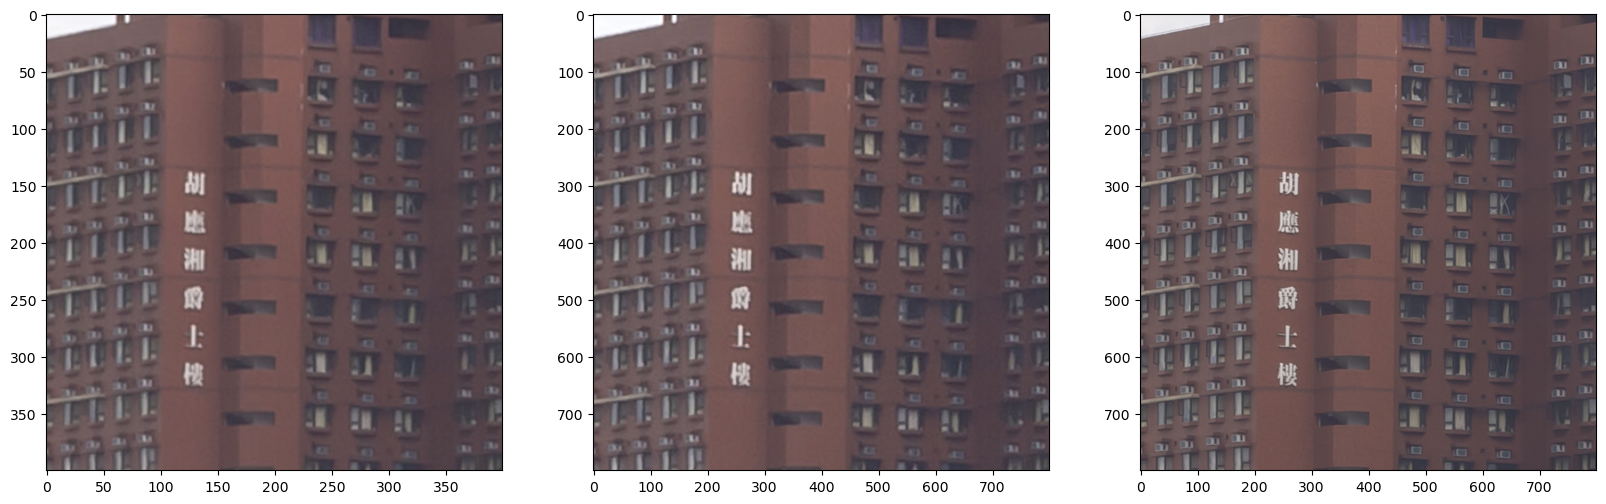

In [65]:
n = 35
ref = images_hr_test[n]

#model = model.to('cpu')
test = images_lr_test[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'realsr_out.png')

plt.subplots(1,3, figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(images_lr_test[n].permute(1,2,0)) #.type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img) #.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(ref.permute(1,2,0)) #.type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
print(ssim_after)

In [76]:
img = cv2.imread('./data/RealSR(V3)/canon/test/2/Canon_046_LR2.png', cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ',img.shape)
 
scale = 2
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('realsr_45_opencv.png', resized) 
print('Resized Dimensions : ',resized.shape)

cv2.destroyAllWindows()

Original Dimensions :  (1150, 1250, 3)
Resized Dimensions :  (2300, 2500, 3)


In [70]:
img_opencv = read_image('realsr_opencv.png')
img_opencv = img_opencv/255.
ssim_after = ssim(img_opencv[None,:], ref[None,:], data_range=1)
print(ssim_after)

tensor(0.9491)


In [72]:
for i in range(len(images_lr)):
    test = images_lr_test[i].to(device)
    ref = images_hr_test[i]
    test = test[None, :]
    model.eval()
    with torch.no_grad():
        preds = model(test)
        img = preds[0].permute(1,2,0).to('cpu')
        ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=1)
        print(i, '-', ssim_after)

0 - tensor(0.9695)
1 - tensor(0.9710)
2 - tensor(0.8189)
3 - tensor(0.8561)
4 - tensor(0.9518)
5 - tensor(0.9620)
6 - tensor(0.9441)
7 - tensor(0.9410)
8 - tensor(0.9672)
9 - tensor(0.9649)
10 - tensor(0.9696)
11 - tensor(0.9605)
12 - tensor(0.9547)
13 - tensor(0.9432)
14 - tensor(0.9198)
15 - tensor(0.9409)
16 - tensor(0.9503)
17 - tensor(0.9580)
18 - tensor(0.9710)
19 - tensor(0.9612)
20 - tensor(0.9621)
21 - tensor(0.9638)
22 - tensor(0.9622)
23 - tensor(0.9613)
24 - tensor(0.9651)
25 - tensor(0.9221)
26 - tensor(0.9292)
27 - tensor(0.9543)
28 - tensor(0.9607)
29 - tensor(0.9606)
30 - tensor(0.9571)
31 - tensor(0.9439)
32 - tensor(0.9478)
33 - tensor(0.9512)
34 - tensor(0.9481)
35 - tensor(0.9513)
36 - tensor(0.9271)
37 - tensor(0.9825)
38 - tensor(0.9508)
39 - tensor(0.9105)
40 - tensor(0.9618)
41 - tensor(0.9675)
42 - tensor(0.9727)
43 - tensor(0.9767)
44 - tensor(0.9767)
45 - tensor(0.9887)
46 - tensor(0.9707)
47 - tensor(0.9793)
48 - tensor(0.9798)
49 - tensor(0.9715)


IndexError: list index out of range

In [68]:
torch.save(model, './saved/v2_zssrlike_09513')

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('./saved/v2_zssrlike_09513.pt')

In [ ]:
# Model class must be defined somewhere
#model = torch.load(PATH)
#model.eval()

#model = torch.jit.load('model_scripted.pt')
#model.eval()

In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [139]:
ref

tensor([[[0.9255, 0.9255, 0.9294,  ..., 0.2510, 0.2471, 0.2471],
         [0.9255, 0.9255, 0.9294,  ..., 0.2431, 0.2392, 0.2392],
         [0.9294, 0.9294, 0.9294,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.2902, 0.3490, 0.3922,  ..., 0.2706, 0.2627, 0.2588],
         [0.2902, 0.3569, 0.3961,  ..., 0.2353, 0.2431, 0.2510],
         [0.2941, 0.3608, 0.4000,  ..., 0.2196, 0.2235, 0.2353]],

        [[0.9176, 0.9176, 0.9216,  ..., 0.2392, 0.2353, 0.2353],
         [0.9176, 0.9176, 0.9216,  ..., 0.2314, 0.2275, 0.2275],
         [0.9216, 0.9216, 0.9216,  ..., 0.2275, 0.2275, 0.2275],
         ...,
         [0.2863, 0.3412, 0.3765,  ..., 0.2627, 0.2510, 0.2471],
         [0.2863, 0.3490, 0.3804,  ..., 0.2275, 0.2353, 0.2431],
         [0.2902, 0.3529, 0.3843,  ..., 0.2118, 0.2157, 0.2275]],

        [[0.9294, 0.9294, 0.9333,  ..., 0.2745, 0.2706, 0.2706],
         [0.9294, 0.9294, 0.9333,  ..., 0.2667, 0.2627, 0.2627],
         [0.9333, 0.9333, 0.9333,  ..., 0.2706, 0.2706, 0.

# deblur

In [166]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(1,1), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def _init_weights(self):
        for m in self.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):           
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255)
        return x

In [147]:
train_data = (images_lr_test[n])[None,:]
train_data = train_data*255.
ds_deblur_train = images_dataset(train_data, train_data)
ds_deblur_test = images_dataset(preds*255., (ref*255.)[None,:])

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

In [148]:
ref.shape, preds.shape

(torch.Size([3, 800, 800]), torch.Size([1, 3, 800, 800]))

In [167]:
def metric_ssim(y_pred, y_true):
    data_range=255.
    y_true = torch.clamp(y_true,0,data_range)    
    return ssim(y_pred, y_true, data_range=data_range)

def loss_tv(y_pred, y_true):
    loss_tv_ = TVLoss()(y_pred)
    loss_l1_ = nn.L1Loss()(y_pred, y_true)
    #if loss_l1_ < 10:
    #    loss_l1_ = 0.
    loss = 1000/loss_tv_ + 0.01*loss_l1_
    return loss

model_deblur = nn_deblur(128)
model_deblur._init_weights()
model_deblur = model_deblur.to(device)
print (model_deblur)
criterion = loss_tv
optimizer = torch.optim.Adam(model_deblur.parameters(), lr=1e-4)          
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)            
trainer = torch_trainer(model=model_deblur,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   epochs=1500,
                                   dataloader=dl_deblur,
                                   metrics=metric_ssim)
history = trainer.train()


nn_deblur(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
  (conv_resc1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (act): GELU(approximate='none')
)
epoch 1/1500; train loss: 1.2647, val_loss: 1.1618; lr=0.0001; metric=0.3119
epoch 2/1500; train loss: 1.1755, val_loss: 1.0721; lr=0.0001; metric=0.3848
epoch 3/1500; train loss: 1.0914, val_loss: 1.0335; lr=0.0001; metric=0.4044
epoch 4/1500; train loss: 1.0575, val_loss: 1.0689; lr=0.0001; metric=0.4005
epoch 5/1500; train loss: 1.0846, val_loss: 1.0836; lr=0.0001; metric=0.3965
epoch 6/1500; train loss: 1.0943, val_loss: 1.0752; lr=0.0001; metric=0.3962
epoch 7/1500; train loss: 1.0822, val_loss: 1.0480; lr=0.0001; metric=0.3999
epoch 8/1500; train loss: 1.0521, val_loss: 1.0056; lr=0.0001; metric=0.4053
epoch 9/1500; train loss: 1.0080, val_loss: 0.9539; lr=0.0001; metric=0.4096
epoch 10/

epoch 101/1500; train loss: 0.2557, val_loss: 0.2157; lr=6.25e-06; metric=0.7005
epoch 102/1500; train loss: 0.2556, val_loss: 0.2155; lr=6.25e-06; metric=0.7007
epoch 103/1500; train loss: 0.2555, val_loss: 0.2154; lr=6.25e-06; metric=0.7009
epoch 104/1500; train loss: 0.2555, val_loss: 0.2153; lr=6.25e-06; metric=0.7010
epoch 105/1500; train loss: 0.2554, val_loss: 0.2152; lr=6.25e-06; metric=0.7012
epoch 106/1500; train loss: 0.2554, val_loss: 0.2150; lr=6.25e-06; metric=0.7013
epoch 107/1500; train loss: 0.2553, val_loss: 0.2149; lr=6.25e-06; metric=0.7015
epoch 108/1500; train loss: 0.2552, val_loss: 0.2147; lr=6.25e-06; metric=0.7017
epoch 109/1500; train loss: 0.2552, val_loss: 0.2146; lr=6.25e-06; metric=0.7019
epoch 110/1500; train loss: 0.2551, val_loss: 0.2145; lr=6.25e-06; metric=0.7020
epoch 111/1500; train loss: 0.2551, val_loss: 0.2144; lr=6.25e-06; metric=0.7021
epoch 112/1500; train loss: 0.2550, val_loss: 0.2143; lr=6.25e-06; metric=0.7023
epoch 113/1500; train loss: 

epoch 203/1500; train loss: 0.2491, val_loss: 0.2092; lr=6.25e-06; metric=0.7131
epoch 204/1500; train loss: 0.2490, val_loss: 0.2091; lr=6.25e-06; metric=0.7132
epoch 205/1500; train loss: 0.2489, val_loss: 0.2091; lr=6.25e-06; metric=0.7134
epoch 206/1500; train loss: 0.2488, val_loss: 0.2090; lr=6.25e-06; metric=0.7135
epoch 207/1500; train loss: 0.2488, val_loss: 0.2089; lr=6.25e-06; metric=0.7136
epoch 208/1500; train loss: 0.2487, val_loss: 0.2089; lr=6.25e-06; metric=0.7137
epoch 209/1500; train loss: 0.2486, val_loss: 0.2089; lr=6.25e-06; metric=0.7138
epoch 210/1500; train loss: 0.2486, val_loss: 0.2088; lr=6.25e-06; metric=0.7140
epoch 211/1500; train loss: 0.2485, val_loss: 0.2087; lr=6.25e-06; metric=0.7141
epoch 212/1500; train loss: 0.2484, val_loss: 0.2087; lr=6.25e-06; metric=0.7142
epoch 213/1500; train loss: 0.2483, val_loss: 0.2086; lr=6.25e-06; metric=0.7143
epoch 214/1500; train loss: 0.2483, val_loss: 0.2086; lr=6.25e-06; metric=0.7145
epoch 215/1500; train loss: 

epoch 305/1500; train loss: 0.2413, val_loss: 0.2028; lr=6.25e-06; metric=0.7275
epoch 306/1500; train loss: 0.2412, val_loss: 0.2027; lr=6.25e-06; metric=0.7277
epoch 307/1500; train loss: 0.2412, val_loss: 0.2026; lr=6.25e-06; metric=0.7278
epoch 308/1500; train loss: 0.2411, val_loss: 0.2026; lr=6.25e-06; metric=0.7280
epoch 309/1500; train loss: 0.2410, val_loss: 0.2025; lr=6.25e-06; metric=0.7281
epoch 310/1500; train loss: 0.2409, val_loss: 0.2024; lr=6.25e-06; metric=0.7283
epoch 311/1500; train loss: 0.2409, val_loss: 0.2024; lr=6.25e-06; metric=0.7284
epoch 312/1500; train loss: 0.2408, val_loss: 0.2023; lr=6.25e-06; metric=0.7286
epoch 313/1500; train loss: 0.2407, val_loss: 0.2022; lr=6.25e-06; metric=0.7287
epoch 314/1500; train loss: 0.2406, val_loss: 0.2022; lr=6.25e-06; metric=0.7289
epoch 315/1500; train loss: 0.2405, val_loss: 0.2021; lr=6.25e-06; metric=0.7290
epoch 316/1500; train loss: 0.2405, val_loss: 0.2020; lr=6.25e-06; metric=0.7292
epoch 317/1500; train loss: 

epoch 407/1500; train loss: 0.2330, val_loss: 0.1960; lr=6.25e-06; metric=0.7437
epoch 408/1500; train loss: 0.2329, val_loss: 0.1959; lr=6.25e-06; metric=0.7439
epoch 409/1500; train loss: 0.2329, val_loss: 0.1958; lr=6.25e-06; metric=0.7441
epoch 410/1500; train loss: 0.2328, val_loss: 0.1958; lr=6.25e-06; metric=0.7442
epoch 411/1500; train loss: 0.2327, val_loss: 0.1957; lr=6.25e-06; metric=0.7444
epoch 412/1500; train loss: 0.2326, val_loss: 0.1956; lr=6.25e-06; metric=0.7445
epoch 413/1500; train loss: 0.2325, val_loss: 0.1955; lr=6.25e-06; metric=0.7447
epoch 414/1500; train loss: 0.2324, val_loss: 0.1955; lr=6.25e-06; metric=0.7449
epoch 415/1500; train loss: 0.2324, val_loss: 0.1954; lr=6.25e-06; metric=0.7451
epoch 416/1500; train loss: 0.2323, val_loss: 0.1953; lr=6.25e-06; metric=0.7452
epoch 417/1500; train loss: 0.2322, val_loss: 0.1952; lr=6.25e-06; metric=0.7454
epoch 418/1500; train loss: 0.2321, val_loss: 0.1952; lr=6.25e-06; metric=0.7456
epoch 419/1500; train loss: 

epoch 509/1500; train loss: 0.2245, val_loss: 0.1891; lr=6.25e-06; metric=0.7612
epoch 510/1500; train loss: 0.2244, val_loss: 0.1891; lr=6.25e-06; metric=0.7614
epoch 511/1500; train loss: 0.2243, val_loss: 0.1890; lr=6.25e-06; metric=0.7615
epoch 512/1500; train loss: 0.2242, val_loss: 0.1889; lr=6.25e-06; metric=0.7617
epoch 513/1500; train loss: 0.2242, val_loss: 0.1889; lr=6.25e-06; metric=0.7619
epoch 514/1500; train loss: 0.2241, val_loss: 0.1888; lr=6.25e-06; metric=0.7621
epoch 515/1500; train loss: 0.2240, val_loss: 0.1887; lr=6.25e-06; metric=0.7623
epoch 516/1500; train loss: 0.2239, val_loss: 0.1887; lr=6.25e-06; metric=0.7624
epoch 517/1500; train loss: 0.2238, val_loss: 0.1886; lr=6.25e-06; metric=0.7626
epoch 518/1500; train loss: 0.2238, val_loss: 0.1885; lr=6.25e-06; metric=0.7628
epoch 519/1500; train loss: 0.2237, val_loss: 0.1885; lr=6.25e-06; metric=0.7629
epoch 520/1500; train loss: 0.2236, val_loss: 0.1884; lr=6.25e-06; metric=0.7631
epoch 521/1500; train loss: 

epoch 611/1500; train loss: 0.2159, val_loss: 0.1824; lr=6.25e-06; metric=0.7793
epoch 612/1500; train loss: 0.2159, val_loss: 0.1823; lr=6.25e-06; metric=0.7795
epoch 613/1500; train loss: 0.2158, val_loss: 0.1822; lr=6.25e-06; metric=0.7797
epoch 614/1500; train loss: 0.2157, val_loss: 0.1821; lr=6.25e-06; metric=0.7799
epoch 615/1500; train loss: 0.2156, val_loss: 0.1820; lr=6.25e-06; metric=0.7801
epoch 616/1500; train loss: 0.2155, val_loss: 0.1820; lr=6.25e-06; metric=0.7802
epoch 617/1500; train loss: 0.2154, val_loss: 0.1819; lr=6.25e-06; metric=0.7804
epoch 618/1500; train loss: 0.2153, val_loss: 0.1818; lr=6.25e-06; metric=0.7806
epoch 619/1500; train loss: 0.2153, val_loss: 0.1817; lr=6.25e-06; metric=0.7808
epoch 620/1500; train loss: 0.2152, val_loss: 0.1817; lr=6.25e-06; metric=0.7810
epoch 621/1500; train loss: 0.2151, val_loss: 0.1816; lr=6.25e-06; metric=0.7811
epoch 622/1500; train loss: 0.2150, val_loss: 0.1815; lr=6.25e-06; metric=0.7813
epoch 623/1500; train loss: 

epoch 713/1500; train loss: 0.2073, val_loss: 0.1754; lr=6.25e-06; metric=0.7978
epoch 714/1500; train loss: 0.2073, val_loss: 0.1753; lr=6.25e-06; metric=0.7979
epoch 715/1500; train loss: 0.2072, val_loss: 0.1753; lr=6.25e-06; metric=0.7981
epoch 716/1500; train loss: 0.2071, val_loss: 0.1752; lr=6.25e-06; metric=0.7983
epoch 717/1500; train loss: 0.2070, val_loss: 0.1751; lr=6.25e-06; metric=0.7985
epoch 718/1500; train loss: 0.2069, val_loss: 0.1751; lr=6.25e-06; metric=0.7987
epoch 719/1500; train loss: 0.2068, val_loss: 0.1750; lr=6.25e-06; metric=0.7988
epoch 720/1500; train loss: 0.2068, val_loss: 0.1749; lr=6.25e-06; metric=0.7990
epoch 721/1500; train loss: 0.2067, val_loss: 0.1748; lr=6.25e-06; metric=0.7992
epoch 722/1500; train loss: 0.2066, val_loss: 0.1748; lr=6.25e-06; metric=0.7994
epoch 723/1500; train loss: 0.2065, val_loss: 0.1747; lr=6.25e-06; metric=0.7996
epoch 724/1500; train loss: 0.2064, val_loss: 0.1746; lr=6.25e-06; metric=0.7997
epoch 725/1500; train loss: 

epoch 815/1500; train loss: 0.1987, val_loss: 0.1683; lr=6.25e-06; metric=0.8160
epoch 816/1500; train loss: 0.1986, val_loss: 0.1682; lr=6.25e-06; metric=0.8161
epoch 817/1500; train loss: 0.1986, val_loss: 0.1681; lr=6.25e-06; metric=0.8163
epoch 818/1500; train loss: 0.1985, val_loss: 0.1681; lr=6.25e-06; metric=0.8165
epoch 819/1500; train loss: 0.1984, val_loss: 0.1680; lr=6.25e-06; metric=0.8166
epoch 820/1500; train loss: 0.1983, val_loss: 0.1679; lr=6.25e-06; metric=0.8168
epoch 821/1500; train loss: 0.1982, val_loss: 0.1679; lr=6.25e-06; metric=0.8170
epoch 822/1500; train loss: 0.1981, val_loss: 0.1678; lr=6.25e-06; metric=0.8172
epoch 823/1500; train loss: 0.1981, val_loss: 0.1678; lr=6.25e-06; metric=0.8173
epoch 824/1500; train loss: 0.1980, val_loss: 0.1678; lr=6.25e-06; metric=0.8175
epoch 825/1500; train loss: 0.1979, val_loss: 0.1677; lr=6.25e-06; metric=0.8177
epoch 826/1500; train loss: 0.1978, val_loss: 0.1676; lr=6.25e-06; metric=0.8179
epoch 827/1500; train loss: 

epoch 918/1500; train loss: 0.1900, val_loss: 0.1612; lr=6.25e-06; metric=0.8336
epoch 919/1500; train loss: 0.1900, val_loss: 0.1611; lr=6.25e-06; metric=0.8338
epoch 920/1500; train loss: 0.1899, val_loss: 0.1610; lr=6.25e-06; metric=0.8339
epoch 921/1500; train loss: 0.1898, val_loss: 0.1609; lr=6.25e-06; metric=0.8341
epoch 922/1500; train loss: 0.1897, val_loss: 0.1608; lr=6.25e-06; metric=0.8342
epoch 923/1500; train loss: 0.1896, val_loss: 0.1607; lr=6.25e-06; metric=0.8344
epoch 924/1500; train loss: 0.1896, val_loss: 0.1607; lr=6.25e-06; metric=0.8346
epoch 925/1500; train loss: 0.1895, val_loss: 0.1606; lr=6.25e-06; metric=0.8347
epoch 926/1500; train loss: 0.1894, val_loss: 0.1606; lr=6.25e-06; metric=0.8349
epoch 927/1500; train loss: 0.1893, val_loss: 0.1605; lr=6.25e-06; metric=0.8350
epoch 928/1500; train loss: 0.1892, val_loss: 0.1605; lr=6.25e-06; metric=0.8352
epoch 929/1500; train loss: 0.1891, val_loss: 0.1604; lr=6.25e-06; metric=0.8354
epoch 930/1500; train loss: 

epoch 1020/1500; train loss: 0.1816, val_loss: 0.1542; lr=6.25e-06; metric=0.8497
epoch 1021/1500; train loss: 0.1816, val_loss: 0.1541; lr=6.25e-06; metric=0.8498
epoch 1022/1500; train loss: 0.1815, val_loss: 0.1541; lr=6.25e-06; metric=0.8500
epoch 1023/1500; train loss: 0.1814, val_loss: 0.1540; lr=6.25e-06; metric=0.8501
epoch 1024/1500; train loss: 0.1813, val_loss: 0.1539; lr=6.25e-06; metric=0.8503
epoch 1025/1500; train loss: 0.1812, val_loss: 0.1538; lr=6.25e-06; metric=0.8504
epoch 1026/1500; train loss: 0.1812, val_loss: 0.1538; lr=6.25e-06; metric=0.8506
epoch 1027/1500; train loss: 0.1811, val_loss: 0.1537; lr=6.25e-06; metric=0.8507
epoch 1028/1500; train loss: 0.1810, val_loss: 0.1537; lr=6.25e-06; metric=0.8509
epoch 1029/1500; train loss: 0.1809, val_loss: 0.1537; lr=6.25e-06; metric=0.8510
epoch 1030/1500; train loss: 0.1808, val_loss: 0.1536; lr=6.25e-06; metric=0.8512
epoch 1031/1500; train loss: 0.1808, val_loss: 0.1535; lr=6.25e-06; metric=0.8513
epoch 1032/1500;

epoch 1121/1500; train loss: 0.1738, val_loss: 0.1478; lr=6.25e-06; metric=0.8638
epoch 1122/1500; train loss: 0.1737, val_loss: 0.1477; lr=6.25e-06; metric=0.8640
epoch 1123/1500; train loss: 0.1736, val_loss: 0.1477; lr=6.25e-06; metric=0.8641
epoch 1124/1500; train loss: 0.1736, val_loss: 0.1476; lr=6.25e-06; metric=0.8642
epoch 1125/1500; train loss: 0.1735, val_loss: 0.1475; lr=6.25e-06; metric=0.8643
epoch 1126/1500; train loss: 0.1734, val_loss: 0.1474; lr=6.25e-06; metric=0.8645
epoch 1127/1500; train loss: 0.1733, val_loss: 0.1474; lr=6.25e-06; metric=0.8646
epoch 1128/1500; train loss: 0.1733, val_loss: 0.1473; lr=6.25e-06; metric=0.8647
epoch 1129/1500; train loss: 0.1732, val_loss: 0.1472; lr=6.25e-06; metric=0.8649
epoch 1130/1500; train loss: 0.1731, val_loss: 0.1472; lr=6.25e-06; metric=0.8650
epoch 1131/1500; train loss: 0.1730, val_loss: 0.1471; lr=6.25e-06; metric=0.8651
epoch 1132/1500; train loss: 0.1730, val_loss: 0.1471; lr=6.25e-06; metric=0.8652
epoch 1133/1500;

epoch 1221/1500; train loss: 0.1668, val_loss: 0.1423; lr=6.25e-06; metric=0.8758
epoch 1222/1500; train loss: 0.1668, val_loss: 0.1423; lr=6.25e-06; metric=0.8759
epoch 1223/1500; train loss: 0.1667, val_loss: 0.1422; lr=6.25e-06; metric=0.8760
epoch 1224/1500; train loss: 0.1667, val_loss: 0.1422; lr=6.25e-06; metric=0.8761
epoch 1225/1500; train loss: 0.1666, val_loss: 0.1421; lr=6.25e-06; metric=0.8762
epoch 1226/1500; train loss: 0.1665, val_loss: 0.1420; lr=6.25e-06; metric=0.8763
epoch 1227/1500; train loss: 0.1665, val_loss: 0.1419; lr=6.25e-06; metric=0.8764
epoch 1228/1500; train loss: 0.1664, val_loss: 0.1419; lr=6.25e-06; metric=0.8765
epoch 1229/1500; train loss: 0.1664, val_loss: 0.1418; lr=6.25e-06; metric=0.8766
epoch 1230/1500; train loss: 0.1663, val_loss: 0.1418; lr=6.25e-06; metric=0.8768
epoch 1231/1500; train loss: 0.1662, val_loss: 0.1418; lr=6.25e-06; metric=0.8769
epoch 1232/1500; train loss: 0.1662, val_loss: 0.1418; lr=6.25e-06; metric=0.8770
epoch 1233/1500;

epoch 1321/1500; train loss: 0.1614, val_loss: 0.1382; lr=6.25e-06; metric=0.8855
epoch 1322/1500; train loss: 0.1614, val_loss: 0.1381; lr=6.25e-06; metric=0.8856
epoch 1323/1500; train loss: 0.1613, val_loss: 0.1381; lr=6.25e-06; metric=0.8856
epoch 1324/1500; train loss: 0.1613, val_loss: 0.1381; lr=6.25e-06; metric=0.8857
epoch 1325/1500; train loss: 0.1612, val_loss: 0.1380; lr=6.25e-06; metric=0.8858
epoch 1326/1500; train loss: 0.1612, val_loss: 0.1380; lr=6.25e-06; metric=0.8859
epoch 1327/1500; train loss: 0.1611, val_loss: 0.1379; lr=6.25e-06; metric=0.8860
epoch 1328/1500; train loss: 0.1611, val_loss: 0.1379; lr=6.25e-06; metric=0.8861
epoch 1329/1500; train loss: 0.1610, val_loss: 0.1379; lr=6.25e-06; metric=0.8862
epoch 1330/1500; train loss: 0.1610, val_loss: 0.1379; lr=6.25e-06; metric=0.8862
epoch 1331/1500; train loss: 0.1610, val_loss: 0.1378; lr=6.25e-06; metric=0.8863
epoch 1332/1500; train loss: 0.1609, val_loss: 0.1378; lr=6.25e-06; metric=0.8864
epoch 1333/1500;

epoch 1422/1500; train loss: 0.1574, val_loss: 0.1354; lr=6.25e-06; metric=0.8932
epoch 1423/1500; train loss: 0.1574, val_loss: 0.1354; lr=6.25e-06; metric=0.8932
epoch 1424/1500; train loss: 0.1573, val_loss: 0.1354; lr=6.25e-06; metric=0.8933
epoch 1425/1500; train loss: 0.1573, val_loss: 0.1353; lr=6.25e-06; metric=0.8934
epoch 1426/1500; train loss: 0.1573, val_loss: 0.1353; lr=6.25e-06; metric=0.8935
epoch 1427/1500; train loss: 0.1572, val_loss: 0.1353; lr=6.25e-06; metric=0.8935
epoch 1428/1500; train loss: 0.1572, val_loss: 0.1353; lr=6.25e-06; metric=0.8936
epoch 1429/1500; train loss: 0.1572, val_loss: 0.1353; lr=6.25e-06; metric=0.8936
epoch 1430/1500; train loss: 0.1571, val_loss: 0.1353; lr=6.25e-06; metric=0.8937
epoch 1431/1500; train loss: 0.1571, val_loss: 0.1352; lr=6.25e-06; metric=0.8938
epoch 1432/1500; train loss: 0.1571, val_loss: 0.1352; lr=6.25e-06; metric=0.8938
epoch 1433/1500; train loss: 0.1570, val_loss: 0.1352; lr=6.25e-06; metric=0.8939
epoch 1434/1500;

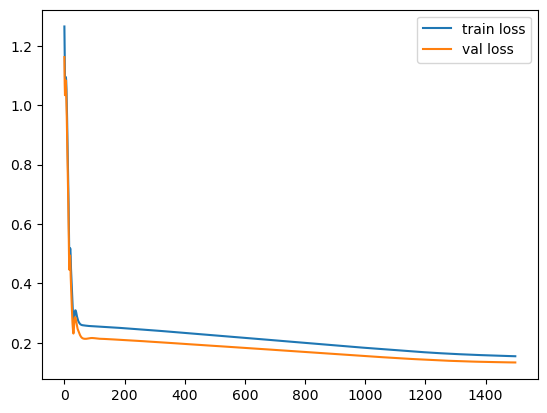

In [168]:
plot_history(history)

AssertionError: Expected tensors with same size, got torch.Size([1, 3, 256, 256]) and torch.Size([1, 3, 900, 1400])

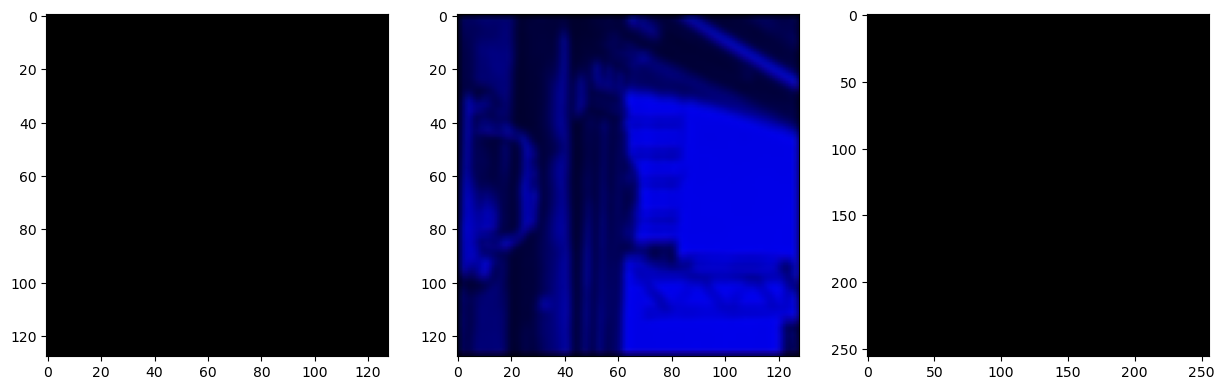

In [120]:
test = (images_lr_patches[0])[None,:]
#test = preds
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0])/255
#torchvision.utils.save_image(to_save, 'out_div2k_hr.png')
#plt.imshow(img.type(torch.LongTensor))


plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_patches[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(images_hr_patches[n].permute(1,2,0).type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=255)
print(ssim_after)


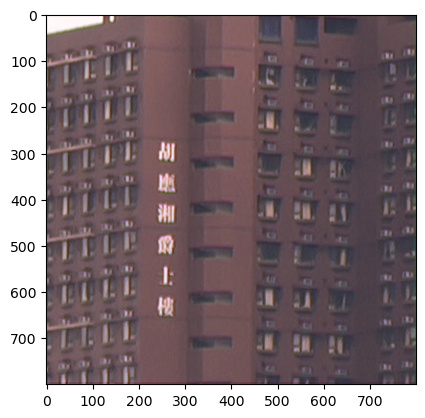

In [169]:
test = preds*255
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0]).detach().cpu()
to_save = to_save/255.
torchvision.utils.save_image(to_save, 'realsr_deblur_out.png')
plt.imshow(img.type(torch.LongTensor))

In [164]:
to_save.shape

torch.Size([3, 800, 800])

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


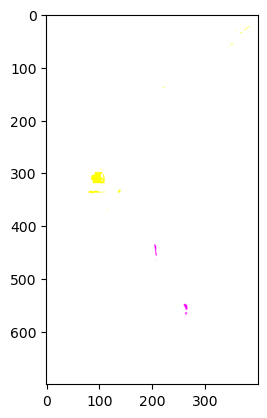

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,